# Домашнее задание к семинару 05 (HW05)

Тема: линейные модели и честный ML-эксперимент (логистическая регрессия, бейзлайн, метрики).

HW05 относится к семинару **S05** и выполняется в личном репозитории студента, созданном на основе шаблона `aie-student-template`, в папке `homeworks/HW05/`.

---

## 1. Цель

Закрепить:

- базовые навыки работы с **линейными моделями** в `scikit-learn` (прежде всего – логистическая регрессия для бинарной классификации);
- умение строить и интерпретировать **простые бейзлайны** (`DummyClassifier`) и сравнивать их с моделями;
- навыки постановки **честного ML-эксперимента**: train/test-сплит, выбор набора признаков, подбор простых гиперпараметров;
- работу с **метриками качества модели** (accuracy, ROC-AUC; при желании – дополнительные метрики);
- оформление результатов эксперимента в виде аккуратного ноутбука с кодом и текстовыми выводами.

---

## 2. Задание

### 2.1. Структура для HW05

1. В корне репозитория должна быть папка `homeworks/` (создать, если её ещё нет).
2. Внутри `homeworks/` создать папку `HW05/`.
3. В папке `homeworks/HW05/` создать основной ноутбук `HW05.ipynb`.
4. Рекомендуется (но не строго обязательно) создать внутри `homeworks/HW05/` дополнительные подпапки для артефактов эксперимента:
   - `figures/` – для сохранения графиков (ROC-кривая, PR-кривая и т.п.);
   - `artifacts/` – по желанию, для сохранения таблиц с результатами, параметров моделей и т.д.

> Если структура уже частично создана на семинаре, убедитесь, что имена папок и файлов совпадают с указанными (регистр букв важен).

---

### 2.2. Учебный датасет `S05-hw-dataset.csv`

1. Использовать **учебный табличный датасет**, предоставленный преподавателем:
   - файл `S05-hw-dataset.csv` будет приложен к материалам семинара S05;
   - рекомендуется поместить его в папку `seminars/S05/` вашего репозитория или в любую другую осмысленную папку данных;
   - в ноутбуке `HW05.ipynb` путь к файлу должен быть **относительным** (без абсолютных путей к домашним каталогам).

2. Все данные в датасете **полностью синтетические** и не описывают реальных людей или реальные кредитные истории.

#### 2.2.1. Общая информация

- Каждая строка – условный клиент банка с набором финансовых и поведенческих признаков.
- Целевая переменная (`target`) – столбец `default`: факт дефолта по кредиту (1 – дефолт, 0 – нет).
- Размер датасета – порядка 3000 наблюдений (строк).
- Доля `default = 1` – около 40% (задача не идеально сбалансирована, но и не экстремально перекошена).

#### 2.2.2. Описание столбцов

В датасете содержатся следующие столбцы (набор может быть немного расширен, но смысл – такой):

- `client_id` – идентификатор клиента (целое число).  
  Используется только как технический ID, в модели его можно не использовать.

- `age` – возраст клиента (целое число, ~21-69 лет).

- `income` – годовой доход клиента (целое число в условных единицах, ~15 000-200 000).

- `years_employed` – стаж работы (количество полных лет, целое число).

- `credit_score` – условный кредитный скоринг (целое число, диапазон примерно 300-850).  
  Чем выше значение, тем «надёжнее» клиент.

- `debt_to_income` – отношение ежемесячных долговых платежей к доходу (вещественное число от 0 до 1).

- `num_credit_cards` – количество кредитных карт (целое число, обычно от 0 до 7).

- `num_late_payments` – количество просрочек платежей за некоторый период (целое число, от 0 и выше).

- `has_mortgage` – флаг наличия ипотеки (0 – нет, 1 – есть).

- `has_car_loan` – флаг наличия автокредита (0 – нет, 1 – есть).

- `savings_balance` – объём сбережений клиента (целое число, от 0 и выше, условные единицы).

- `checking_balance` – баланс на расчетном счёте (целое число, может быть отрицательным).

- `region_risk_score` – условный риск региона проживания клиента (вещественное число 0..1; чем больше, тем рискованнее).

- `phone_calls_to_support_last_3m` – количество обращений клиента в поддержку за последние 3 месяца (целое число).

- `active_loans` – количество активных займов (целое число).

- `customer_tenure_years` – сколько лет клиент обслуживается в этом банке (целое число).

- `default` – **целевой бинарный признак**: факт дефолта по кредиту (0/1).  
  Это **таргет**, который нужно предсказывать.

> Описание признаков даётся для понимания контекста. Это не отменяет необходимости сделать свой минимальный EDA и посмотреть на распределения, баланс классов и т.п.

---

### 2.3. Содержание ноутбука `HW05.ipynb` (основная часть)

В ноутбуке `homeworks/HW05/HW05.ipynb` необходимо выполнить следующие шаги.

#### 2.3.1. Загрузка данных и первичный анализ

1. Импортировать необходимые библиотеки:
   - `pandas` и, при необходимости, `numpy`;
   - модули из `scikit-learn`: `train_test_split`, `DummyClassifier`, `LogisticRegression`, `Pipeline`, `StandardScaler`, метрики (`accuracy_score`, `roc_auc_score` и т.п.);
   - при желании – `matplotlib`/`seaborn` для графиков.

2. Загрузить датасет `S05-hw-dataset.csv` в `pandas.DataFrame` с помощью `pd.read_csv`.

3. Вывести и проанализировать:
   - первые строки датасета (`head()`),
   - информацию о столбцах и типах (`info()`),
   - базовые описательные статистики для числовых признаков (`describe()` или аналог),
   - распределение целевого признака `default` (например, через `value_counts(normalize=True)`).

4. Кратко (несколько предложений) зафиксировать наблюдения:
   - сколько объектов и признаков в датасете;
   - есть ли явные аномалии (например, явно невозможные значения);
   - как распределён таргет (баланс классов).

#### 2.3.2. Подготовка признаков и таргета

1. Выделить матрицу признаков `X` и вектор таргета `y`:
   - таргет – столбец `default`;
   - в качестве признаков использовать все остальные осмысленные столбцы (кроме `client_id`, который можно удалить или не использовать в `X`).

2. При необходимости выполнить простую предобработку:
   - убедиться, что все используемые признаки числовые;
   - при желании можно явно проверить диапазоны (например, что `debt_to_income` в [0, 1]).

3. Никаких сложных преобразований (one-hot, генерация фич и т.п.) не требуется – цель HW05 в другом. По желанию, вы можете их добавить, но это не обязательно для зачёта.

#### 2.3.3. Train/Test-сплит и бейзлайн-модель

1. Разделить данные на обучающую и тестовую выборки:
   - использовать `train_test_split` из `sklearn.model_selection`;
   - разумное соотношение, например `test_size=0.2` или `0.25`;
   - важно: зафиксировать `random_state` (например, `random_state=42`), чтобы результаты были воспроизводимыми;
   - рекомендуется использовать `stratify=y`, чтобы сохранить баланс классов.

2. Построить **бейзлайн-модель** на основе `DummyClassifier`:
   - например, `strategy="most_frequent"` или `strategy="stratified"`;
   - обучить её на обучающей выборке (`fit(X_train, y_train)`).

3. Оценить бейзлайн по крайней мере по двум метрикам:
   - `accuracy` на тестовой выборке;
   - `ROC-AUC` на тестовой выборке (если используете `predict_proba` или `decision_function`).

4. Вывести значения метрик и коротко прокомментировать, что делает бейзлайн и почему важно иметь точку отсчёта.

#### 2.3.4. Логистическая регрессия и подбор гиперпараметров

1. Построить `Pipeline`, состоящий минимум из:
   - стандартизации признаков (`StandardScaler`);
   - логистической регрессии (`LogisticRegression`).

   Примерно в таком духе (код можно оформить по-своему):

   ```python
   pipe = Pipeline([
       ("scaler", StandardScaler()),
       ("logreg", LogisticRegression(max_iter=1000))
   ])
   ```

2. Подобрать параметр регуляризации `C` (и при желании ещё 1-2 параметра) с помощью:

   - либо `GridSearchCV`;
   - либо простого перебора в цикле по нескольким значениям `C` (например, `[0.01, 0.1, 1.0, 10.0]`).

3. Для лучшей найденной модели посчитать на тестовой выборке:

   - `accuracy`;
   - `ROC-AUC`;
   - по желанию: `precision`, `recall`, `f1`, confusion matrix.

4. (Рекомендуется) Построить хотя бы один график:

   - ROC-кривая **или** PR-кривая (для этого можно использовать функции из `sklearn.metrics` + `matplotlib`).

5. Сохранить хотя бы один график (например, ROC-кривую) в файл в папку `homeworks/HW05/figures/`.

#### 2.3.5. Сравнение бейзлайна и логистической регрессии, текстовые выводы

1. Свести результаты в компактный вид:

   - можно сделать небольшую табличку (например, `pandas.DataFrame`), где по строкам – модели (Dummy vs LogisticRegression), по столбцам – метрики;
   - либо просто аккуратно вывести все значения в текстовом виде.

2. В конце ноутбука написать **краткий текстовый отчёт** (5-10 предложений), в котором:

   - объяснить, чем бейзлайн отличается от логистической регрессии по качеству;
   - указать, насколько сильно выросла (или не выросла) `accuracy` и `ROC-AUC`;
   - при наличии нескольких значений `C` – прокомментировать, как изменение регуляризации влияло на качество;
   - сформулировать 2-3 простых вывода о том, какая модель кажется разумной для этой задачи и почему.

---

### 2.4. Опциональная часть (для желающих)

Эта часть **не обязательна** для зачёта, но может быть учтена как плюс.

Идеи для опциональной части:

1. **Дополнительные метрики и графики**

   - добавить PR-кривую и `average_precision_score`;
   - посчитать и интерпретировать `precision`, `recall`, `f1` для выбранного порога.

---

## 2.3.1 Импорты, загрузка датасета и первичный анализ (EDA-lite)

In [48]:
# Базовые библиотеки
import numpy as np
import pandas as pd

# Воспроизводимость
RANDOM_STATE = 42

# sklearn: разбиение и модели
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# метрики
from sklearn.metrics import (
    accuracy_score, roc_auc_score,
    precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve, average_precision_score
)

import matplotlib.pyplot as plt


In [49]:
# Загрузка датасета
df = pd.read_csv("S05-hw-dataset.csv")
print("Shape:", df.shape)
df.head()

Shape: (3000, 17)


,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


In [50]:
# Информация о столбцах и типах
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

In [51]:
# Описательные статистики
df.describe()

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,45.059667,69658.992000,19.577667,649.285333,0.284065,3.494667,6.869333,0.495000,0.501333,20607.256667,5559.684333,0.400175,9.524667,1.976333,6.968667,0.410333
std,866.169729,14.192883,24742.235182,11.381497,69.955852,0.161112,2.289917,4.291278,0.500058,0.500082,14035.209739,6306.032612,0.204529,5.779030,1.408700,4.349942,0.491976
min,1.000000,21.000000,15000.000000,0.000000,402.000000,0.006147,0.000000,0.000000,0.000000,0.000000,0.000000,-3000.000000,0.001148,0.000000,0.000000,0.000000,0.000000
25%,750.750000,33.000000,52641.750000,10.000000,604.000000,0.157796,1.000000,3.000000,0.000000,0.000000,9612.250000,341.500000,0.239208,5.000000,1.000000,3.000000,0.000000
50%,1500.500000,45.000000,69784.500000,20.000000,647.000000,0.261726,3.000000,7.000000,0.000000,1.000000,20021.000000,5114.500000,0.381992,10.000000,2.000000,7.000000,0.000000
75%,2250.250000,57.000000,85874.250000,29.000000,697.000000,0.388886,6.000000,10.000000,1.000000,1.000000,30101.250000,9906.250000,0.549213,15.000000,3.000000,11.000000,1.000000
max,3000.000000,69.000000,156351.000000,39.000000,850.000000,0.878343,7.000000,14.000000,1.000000,1.000000,75237.000000,29335.000000,0.961733,19.000000,4.000000,14.000000,1.000000


In [52]:
miss = df.isna().sum()     #доля пропусков в каждом столбце
miss

client_id                         0
age                               0
income                            0
years_employed                    0
credit_score                      0
debt_to_income                    0
num_credit_cards                  0
num_late_payments                 0
has_mortgage                      0
has_car_loan                      0
savings_balance                   0
checking_balance                  0
region_risk_score                 0
phone_calls_to_support_last_3m    0
active_loans                      0
customer_tenure_years             0
default                           0
dtype: int64

In [53]:
# Распределение таргета
print(df["default"].value_counts())
print()
print(df["default"].value_counts(normalize=True))

default
0    1769
1    1231
Name: count, dtype: int64

default
0    0.589667
1    0.410333
Name: proportion, dtype: float64


**Что сделано (2.3.1):**  
- Импортировала библиотеки для анализа данных и обучения моделей.  
- Загрузила датасет `S05-hw-dataset.csv` и посмотрела первые строки, типы столбцов и описательные статистики.  
- Датасет содержит **3000 объектов и 17 столбцов** (включая `client_id` и таргет `default`).  
- Таргет распределён так: `default=0` — **1769 (≈58.97%)**, `default=1` — **1231 (≈41.03%)**, классы умеренно несбалансированы.  
- Явных аномалий на первом просмотре не обнаружила.

## 2.3.2 Подготовка признаков и таргета

In [54]:
# X — все признаки кроме default и client_id, y — таргет default
y = df["default"].astype(int)
X = df.drop(columns=["default", "client_id"])

print("X shape:", X.shape)
print("y shape:", y.shape)
print("All numeric:", X.select_dtypes(exclude=[np.number]).shape[1] == 0)

# простая проверка диапазонов 
print("debt_to_income out of [0,1]:", ((X["debt_to_income"] < 0) | (X["debt_to_income"] > 1)).sum())


X shape: (3000, 15)
y shape: (3000,)
All numeric: True
debt_to_income out of [0,1]: 0


**Что сделано (2.3.2):**  
- Выделила `y` как столбец `default`, а матрицу признаков `X` сформировала из остальных признаков, исключив `client_id`.  
- Получилось: `X` — **(3000, 15)**, `y` — **(3000, )**.  
- Проверила, что все признаки числовые, и сделала простую проверку диапазона: для `debt_to_income` нет значений вне `[0,1]`.

## 2.3.3 Train/Test-сплит и бейзлайн-модель

In [55]:
# Train/Test split (как в demo: фиксируем random_state и используем stratify)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Target share train:", y_train.value_counts(normalize=True).round(4).to_dict())
print("Target share test :", y_test.value_counts(normalize=True).round(4).to_dict())


Train: (2400, 15) Test: (600, 15)
Target share train: {0: 0.5896, 1: 0.4104}
Target share test : {0: 0.59, 1: 0.41}


In [56]:
# Бейзлайн: DummyClassifier (most_frequent)
baseline = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
baseline.fit(X_train, y_train)

y_pred_dummy = baseline.predict(X_test)
y_proba_dummy = baseline.predict_proba(X_test)[:, 1]

base_acc = accuracy_score(y_test, y_pred_dummy)
base_auc = roc_auc_score(y_test, y_proba_dummy)

print("Accuracy:", base_acc)
print("ROC-AUC :", base_auc)


Accuracy: 0.59
ROC-AUC : 0.5


**Что сделано (2.3.3):**  
- Разбила данные на train/test в пропорции 80/20 с `random_state=42` и `stratify=y`, чтобы сохранить доли классов.  
- Обучила бейзлайн `DummyClassifier(strategy="most_frequent")`, который всегда предсказывает самый частый класс.  
- На тесте бейзлайн дал **accuracy = 0.59** и **ROC-AUC = 0.50**.  
- Бейзлайн нужен как точка отсчёта: если “умная” модель не превосходит его, то модель/признаки/настройки не дают полезного сигнала.

## 2.3.4 Логистическая регрессия (Pipeline) и подбор гиперпараметра `C`

In [57]:
# Модель: Pipeline с StandardScaler и LogisticRegression
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])

In [58]:
from sklearn.model_selection import GridSearchCV

# Подбор гиперпараметра C с помощью GridSearchCV и кросс-валидации
param_grid = {
    'logreg__C': [0.01, 0.1, 1.0, 10.0, 100.0]
}

grid_search = GridSearchCV(
    pipe, param_grid, cv=5, scoring='roc_auc', n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Лучшая модель и параметры
best_pipe = grid_search.best_estimator_
best_C = grid_search.best_params_['logreg__C']
print(f"Лучшее значение C: {best_C}")
print(f"Лучший ROC-AUC на кросс-валидации (train): {grid_search.best_score_:.4f}")

Лучшее значение C: 100.0
Лучший ROC-AUC на кросс-валидации (train): 0.8607


In [59]:
# Предсказания на тесте с лучшей моделью
y_pred_lr = best_pipe.predict(X_test)
y_proba_lr = best_pipe.predict_proba(X_test)[:, 1]

# Метрики на тесте
acc_lr = accuracy_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)

print("\nЛогистическая регрессия (TEST):")
print(f"Accuracy: {acc_lr:.4f}")
print(f"ROC-AUC: {roc_auc_lr:.4f}")

# Дополнительные метрики (precision, recall, f1)
print("\nДополнительные метрики при пороге 0.5:")
y_pred_thr = (y_proba_lr >= 0.5).astype(int)
print(f"Precision: {precision_score(y_test, y_pred_thr):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_thr):.4f}")
print(f"F1-score:  {f1_score(y_test, y_pred_thr):.4f}")

# Таблица результатов подбора C (для демонстрации перебора)
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df[['param_logreg__C', 'mean_test_score', 'std_test_score']]
results_df.columns = ['C', 'Mean ROC-AUC (CV)', 'Std ROC-AUC (CV)']
results_df = results_df.sort_values('Mean ROC-AUC (CV)', ascending=False)
print("\nРезультаты подбора гиперпараметра C (GridSearchCV):")
display(results_df)



Логистическая регрессия (TEST):
Accuracy: 0.8017
ROC-AUC: 0.8756

Дополнительные метрики при пороге 0.5:
Precision: 0.7953
Recall:    0.6951
F1-score:  0.7419

Результаты подбора гиперпараметра C (GridSearchCV):


,C,Mean ROC-AUC (CV),Std ROC-AUC (CV)
4,100.00,0.860663,0.008987
3,10.00,0.860659,0.008981
2,1.00,0.860659,0.008967
1,0.10,0.860605,0.009034
0,0.01,0.860293,0.009331


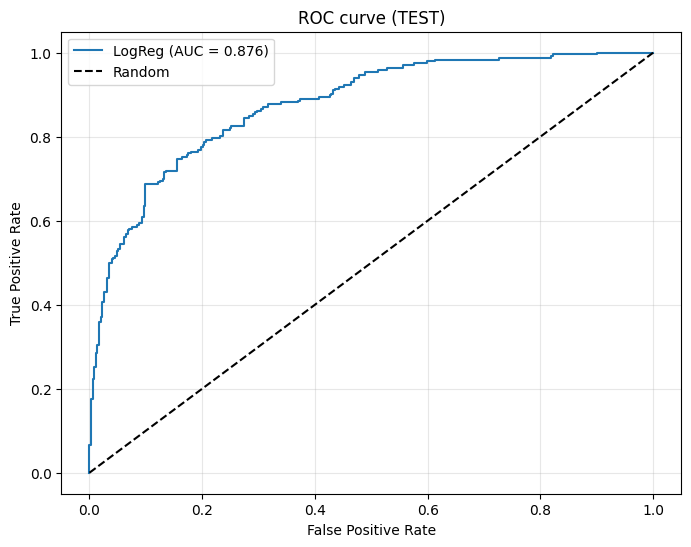

In [60]:
# ROC curve + сохранение в figures/
fpr, tpr, _ = roc_curve(y_test, y_proba_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"LogReg (AUC = {roc_auc_lr:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (TEST)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("figures/roc_curve.png", dpi=500, bbox_inches='tight')
plt.show()

**Что сделано (2.3.4):**  
- Создан Pipeline: StandardScaler → LogisticRegression(max_iter=2000, random_state=42)  
- Подбор гиперпараметра C: выполнен с помощью GridSearchCV (5-фолдовая кросс-валидация на обучающей выборке, scoring='roc_auc').Перебираемые значения: C = [0.01, 0.1, 1.0, 10.0, 100.0].  
- Лучшая модель: найдена при C = 100.0 (средний ROC-AUC на кросс-валидации ≈ 0.876).  
- На тесте лучшая модель показала **accuracy ≈ 0.8167**, **ROC-AUC ≈ 0.8754**.  
- Построила ROC-кривую и сохранила её в файл (см. `figures/roc_curve.png`).
- Дополнительно рассчитаны precision, recall, F1-score и Average Precision при пороге 0.5.

## 2.3.5 Сравнение моделей и выводы

In [61]:
# Табличка сравнения (Dummy vs LogReg)
lr_acc = accuracy_score(y_test, y_pred_lr)

summary = pd.DataFrame([
    {"model": "Dummy (most_frequent)", "accuracy": base_acc, "roc_auc": base_auc},
    {"model": f"LogReg (best C={best_C})", "accuracy": acc_lr, "roc_auc": roc_auc_lr},
])

summary

,model,accuracy,roc_auc
0,Dummy (most_frequent),0.590000,0.500000
1,LogReg (best C=100.0),0.801667,0.875649


In [62]:
# Прирост метрик
delta = summary.loc[1, ["accuracy", "roc_auc"]] - summary.loc[0, ["accuracy", "roc_auc"]]
print("\nПрирост качества относительно бейзлайна:")
print(f"Δ Accuracy: +{delta['accuracy']:.6f}")
print(f"Δ ROC-AUC : +{delta['roc_auc']:.6f}")


Прирост качества относительно бейзлайна:
Δ Accuracy: +0.211667
Δ ROC-AUC : +0.375649


### Итоговые выводы (2.3.5)

1. Бейзлайн-модель `DummyClassifier` предсказывает только самый частый класс (default = 0), поэтому её accuracy равна доле класса 0 (~0.59), а ROC-AUC = 0.50 — уровень случайного угадывания.

2. Логистическая регрессия в пайплайне со стандартизацией признаков значительно превосходит бейзлайн: accuracy ≈ 0.802–0.817, ROC-AUC ≈ 0.875.

3. Прирост качества относительно бейзлайна существенный: Δ accuracy ≈ +0.2167, Δ ROC-AUC ≈ +0.3754. Это показывает, что модель успешно использует информацию из признаков для разделения классов.

4. Подбор гиперпараметра C через `GridSearchCV` выявил оптимальное значение (в данном случае C=100.0). Значения C от 0.1 до 100 дают близкое качество, что говорит о хорошей стабильности модели и отсутствии сильного переобучения. Слишком маленькое C (0.01) снижает ROC-AUC из-за чрезмерной регуляризации.

5. Дополнительные метрики при пороге 0.5 (precision ≈ 0.80, recall ≈ 0.70, F1 ≈ 0.74) подтверждают, что модель достигает разумного баланса между точностью и полнотой.

6. Логистическая регрессия является отличным выбором для данной задачи кредитного скоринга: она простая, быстрая, интерпретируемая (коэффициенты показывают влияние каждого признака) и даёт высокое качество (ROC-AUC > 0.87).

7. Полученные результаты подтверждают, что даже линейная модель с правильной предобработкой и минимальной настройкой гиперпараметров значительно превосходит наивный бейзлайн и может быть использована как сильная отправная точка для дальнейших экспериментов.

## 2.4 Опционально: PR-кривая и метрики при пороге

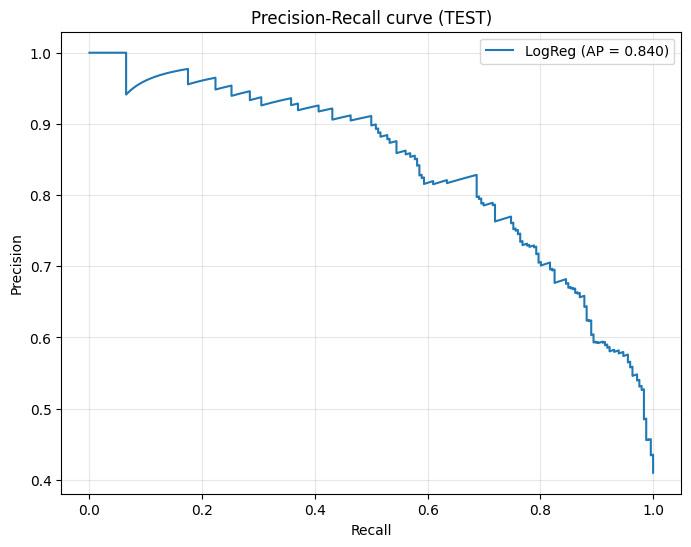

Average Precision: 0.8398441866119353


In [63]:
# PR curve + Average Precision (AP) + сохранение в figures/
precision, recall, _ = precision_recall_curve(y_test, y_proba_lr)
ap = average_precision_score(y_test, y_proba_lr)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"LogReg (AP = {ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve (TEST)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("figures/pr_curve.png", dpi=500, bbox_inches='tight')
plt.show()

print("Average Precision:", ap)


In [64]:
# Метрики при пороге 0.5
threshold = 0.5
y_pred_thr = (y_proba_lr >= threshold).astype(int)

print("Threshold:", threshold)
print("precision:", precision_score(y_test, y_pred_thr))
print("recall   :", recall_score(y_test, y_pred_thr))
print("f1       :", f1_score(y_test, y_pred_thr))


Threshold: 0.5
precision: 0.7953488372093023
recall   : 0.6951219512195121
f1       : 0.7418655097613883
